use VAE example to make code


Research VAEs to make VAE


###Imports

In [1]:
# Library imports
import numpy as np
import pandas as pd
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchviz import make_dot
import matplotlib.pyplot as plt
from PIL import Image
import math
%matplotlib inline
from collections import OrderedDict

from skimage import io, transform
from sklearn.metrics import roc_auc_score
# import umap
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [2]:
torch.__version__

'1.7.0'

### Directories

In [37]:
# Danny's Working Directory
data_dir = 'data/celeba'
save_dir = 'models'

# Danny's CelebA Paths
os.chdir('/home')
os.listdir()

['.git',
 'code',
 'docker',
 '.ipynb_checkpoints',
 '.gitignore',
 'data',
 'models',
 'README.md']

# The Data

### Load Data

### Transforms

In [4]:
img_shape = (64, 64)
scale_mu = 0.1307
scale_sd = 0.3081


# transforms
tfms_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(img_shape),
    transforms.ToTensor(),
    transforms.Normalize((scale_mu,), (scale_sd,))
])

tfms_val = tfms_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(img_shape),
    transforms.ToTensor(),
    transforms.Normalize((scale_mu,), (scale_sd,))
])

### CelebA Class

In [5]:
class CelebA(Dataset):
  def __init__(self, root_dir: str, partition: str, transform=None):
    # the image data
    self.img_dir = f"{root_dir}/img_align_celeba"

    # the partition data
    if partition=='train':
      self.partition_ix = 0
    elif partition=='val':
      self.partition_ix = 1
    elif partition=='test':
      self.partition_ix = 2
    else:
      raise ValueError("partition must be one of 'train', 'val', or 'test'")

    df_partitions = pd.read_csv(f"{root_dir}/list_eval_partition.csv")
    self.df_partitions = df_partitions[df_partitions['partition']==self.partition_ix]

    # the attribute data
    df_attributes = pd.read_csv(f"{root_dir}/list_attr_celeba.csv")

    # filter the attributes
    self.df_attributes = self.df_partitions.merge(df_attributes, how='left', on='image_id').drop(columns=['partition'])

    # transforms
    self.transform = transform

  def __len__(self):
    return self.df_attributes.shape[0]

  def __getitem__(self, ix):
    # image
    filepath = f"{self.img_dir}/{self.df_attributes.image_id[ix]}"
    image = Image.open(filepath)
    if self.transform:
      image = self.transform(image)

    # attributes
    attributes =self.df_attributes.iloc[ix, 1:].to_dict()

    return {'image': image, 'attributes': attributes}


In [27]:
# data settings:
batch_size=128 #input batch size for training (default: 64)
batch_size_test=1000 

# misc settings SET EACH TIME
device = torch.device(3)
kwargs = {'num_workers': 10, 'pin_memory': True}

# datasets
train_data = CelebA(data_dir, "train", transform = tfms_train)
test_data = CelebA(data_dir, "test", transform = tfms_test)

# Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)

# Define the VAE

### Encoder

In [28]:
class Encoder(nn.Module):
  def __init__(self, coarse_resolution = (4,4), hid_channels=(8, 12, 16)):
    super(Encoder, self).__init__()

    self.coarse_resolution = coarse_resolution
    
    # block 1:
    self.block1 = nn.Sequential(OrderedDict(
      conv = nn.Conv2d(in_channels=1, out_channels=hid_channels[0], kernel_size=5, stride=1, padding=2, bias=False),
      bn = nn.BatchNorm2d(hid_channels[0]),
      relu = nn.ReLU(),
      pool = nn.MaxPool2d(2)
    ))

    # block 2:
    self.block2 = nn.Sequential(OrderedDict(
      conv = nn.Conv2d(in_channels=hid_channels[0], out_channels=hid_channels[1], kernel_size=3, stride=1, padding=1, bias=False),
      bn = nn.BatchNorm2d(num_features=hid_channels[1]),
      relu = nn.ReLU(),
      pool = nn.MaxPool2d(2)
    ))

    # block 3:
    self.block3 = nn.Sequential(OrderedDict(
      conv = nn.Conv2d(in_channels=hid_channels[1], out_channels=hid_channels[2], kernel_size=3, stride=1, padding=1, bias=False),
      bn = nn.BatchNorm2d(num_features=hid_channels[2]),
      relu = nn.ReLU(),
      pool = nn.AdaptiveAvgPool2d(output_size=self.coarse_resolution),
      flatten = nn.Flatten()
    ))

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    z = self.block3(x)

    return(z)

In [29]:
encoder = Encoder().to(device)
batch_ix = 7
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images = batch['image']

    z = encoder(images.to(device))
    print(images.shape, z.shape)
    break

torch.Size([128, 1, 64, 64]) torch.Size([128, 256])


### Decoder

In [30]:
class Decoder(nn.Module):
  def __init__(self, coarse_resolution = (4,4), hid_channels=(16, 12, 8)):
    super(Decoder, self).__init__()

    self.coarse_resolution = coarse_resolution
    self.zdim = hid_channels[0]*self.coarse_resolution[0]*self.coarse_resolution[1]
    
    # block 1:
    self.block1 = nn.Sequential(OrderedDict(
      unflatten = nn.Unflatten(-1, (hid_channels[0], self.coarse_resolution[0], self.coarse_resolution[1])),
      conv = nn.Conv2d(in_channels=hid_channels[0], out_channels=hid_channels[1], kernel_size=3, stride=1, padding=1, bias=False),
      bn = nn.BatchNorm2d(hid_channels[1]),
      relu = nn.ReLU(),
      upsample = nn.UpsamplingBilinear2d(scale_factor=2)
    ))

    # block 2:
    self.block2 = nn.Sequential(OrderedDict(
      conv = nn.Conv2d(in_channels=hid_channels[1], out_channels=hid_channels[2], kernel_size=3, stride=1, padding=1, bias=False),
      bn = nn.BatchNorm2d(num_features=hid_channels[2]),
      relu = nn.ReLU(),
      upsample = nn.UpsamplingBilinear2d(scale_factor=2)
    ))

    # block 3:
    self.block3 = nn.Sequential(OrderedDict(
      conv = nn.Conv2d(in_channels=hid_channels[2], out_channels=hid_channels[2], kernel_size=3, stride=1, padding=1, bias=False),
      bn = nn.BatchNorm2d(num_features=hid_channels[2]),
      relu = nn.ReLU(),
      upsample = nn.UpsamplingBilinear2d(size=img_shape)
    ))

    # touch-up 
    self.touchup = nn.Sequential(OrderedDict(
        conv = nn.Conv2d(in_channels=hid_channels[2], out_channels=1, kernel_size=3, stride=1, padding=1),
        sig = nn.Sigmoid()
    ))

  def forward(self, z):
    z = self.block1(z)
    z = self.block2(z)
    z = self.block3(z)
    x = self.touchup(z)

    return(x)

In [31]:
decoder = Decoder().to(device)
batch_ix = 5
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images = batch['image']

    z = encoder(images.to(device))
    xp = decoder(z)
    print(images.shape, z.shape, xp.shape)
    break

torch.Size([128, 1, 64, 64]) torch.Size([128, 256]) torch.Size([128, 1, 64, 64])


### VAE

In [32]:
class VAE(nn.Module):
    def __init__(self, 
                 coarse_resolution = (4,4), 
                 hid_channels_encoder=(8, 12, 16),
                 hid_channels_decoder=(16, 12, 8), 
                 hdim = 128):     
        super(VAE, self).__init__()

        self.coarse_resolution = coarse_resolution
        self.hid_channels_encoder = hid_channels_encoder
        self.hid_channels_decoder = hid_channels_decoder
        self.hdim = hdim
        self.zdim = coarse_resolution[0]*coarse_resolution[1]*hid_channels_encoder[2]
        
        # encoder/decoder
        self.encoder = Encoder(coarse_resolution, hid_channels_encoder)
        self.decoder = Decoder(coarse_resolution, hid_channels_decoder)

        # reparametrization
        self.mu = nn.Linear(self.zdim, self.hdim)
        self.logvar = nn.Linear(self.zdim, self.hdim)
        self.zdecode = nn.Linear(self.hdim, self.zdim)
        
    def encode(self, x):
        z = self.encoder(x)
        return self.mu(z), self.logvar(z)
    
    def sample(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decode(self, h):
        z = self.zdecode(h)
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        h = self.sample(mu, log_var)
        return self.decode(h), mu, log_var

In [33]:
vae = VAE(coarse_resolution=(4,4), hdim=32).to(device)
print("Number of free parameters: ", sum(p.numel() for p in vae.parameters() if p.requires_grad))
batch_ix = 5
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images = batch['image']

    xp, mu, logvar = vae(images.to(device))
    print(images.shape, xp.shape, mu.shape, logvar.shape)
    break

Number of free parameters:  31057
torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64]) torch.Size([128, 32]) torch.Size([128, 32])


# Train

In [39]:
beta=0.025
optimizer = optim.Adam(vae.parameters(), lr=0.01)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var, beta=1):
    BCE = F.binary_cross_entropy(recon_x.view(-1, np.prod(img_shape)), x.view(-1, np.prod(img_shape)), reduction='mean')
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE+beta*KLD, BCE, KLD

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        images = batch['image']
        images = images.to(device)
        optimizer.zero_grad()
        
        recon, mu, log_var = vae(images)
        images = images*scale_sd+scale_mu
        loss, _, _ = loss_function(recon, images, mu, log_var, beta=beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(images)))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image']
            images = images.to(device)
            recon, mu, log_var = vae(images)
            
            # sum up batch loss
            images = images*scale_sd+scale_mu
            loss, bce, kld = loss_function(recon, images, mu, log_var, beta=beta)
            test_loss += loss.item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss

In [41]:
best_test = 10**10
for epoch in range(1):
    train(epoch)
    test_loss = test()

    if test_loss < best_test:
      best_test = test_loss
      torch.save(vae.state_dict(), 'vae.pt')

vae.load_state_dict(torch.load('vae.pt'))

Train Epoch: 0 [0/162770 (0%)]	Loss: 0.004456
Train Epoch: 0 [16384/162770 (10%)]	Loss: 0.004407
Train Epoch: 0 [32768/162770 (20%)]	Loss: 0.004328
Train Epoch: 0 [49152/162770 (30%)]	Loss: 0.004394
Train Epoch: 0 [65536/162770 (40%)]	Loss: 0.004366
Train Epoch: 0 [81920/162770 (50%)]	Loss: 0.004410
Train Epoch: 0 [98304/162770 (60%)]	Loss: 0.004452
Train Epoch: 0 [114688/162770 (70%)]	Loss: 0.004415
Train Epoch: 0 [131072/162770 (81%)]	Loss: 0.004325
Train Epoch: 0 [147456/162770 (91%)]	Loss: 0.004408
====> Epoch: 0 Average loss: 0.0044
====> Test set loss: 0.0006


<All keys matched successfully>

# Save the encoder to drive

In [45]:
vae.encoder

Encoder(
  (block1): Sequential(
    (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (conv): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (conv): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pool): AdaptiveAvgPool2d(output_size=(4, 4))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
)

In [44]:
torch.save(vae.encoder.state_dict(), save_dir + '/celeba_encoder.pt')

# Visualize

In [46]:
batch_ix = 5
vae.eval()
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images = batch['image']
    with torch.no_grad():
      xp, mu, logvar = vae(images.to(device))
    print(images.shape, xp.shape, mu.shape, logvar.shape)
    break

torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64]) torch.Size([128, 32]) torch.Size([128, 32])


In [47]:
# Helper function to show batch of images
def show_images(images, nrow=8):
    plt.figure(figsize=(20,20))
    """Show image with landmarks for a batch of samples."""
    num_images = images.shape[0]
    grid_border_size = 1

    grid = utils.make_grid(images, nrow=nrow, padding = grid_border_size, scale_each=True, normalize=True)[0]
    plt.imshow(grid.numpy().transpose((0, 1)))

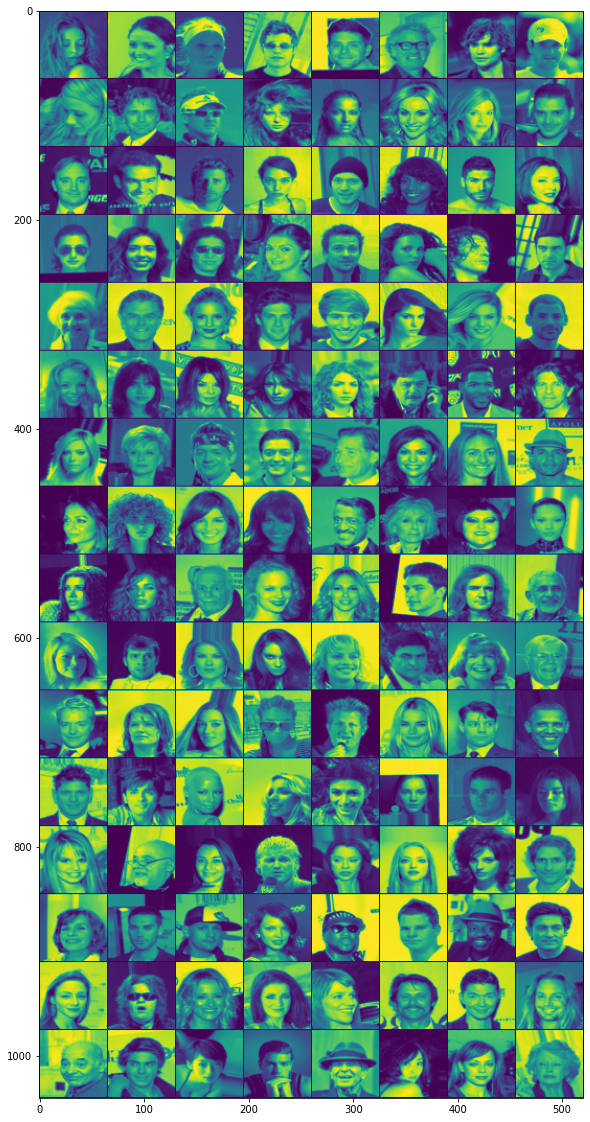

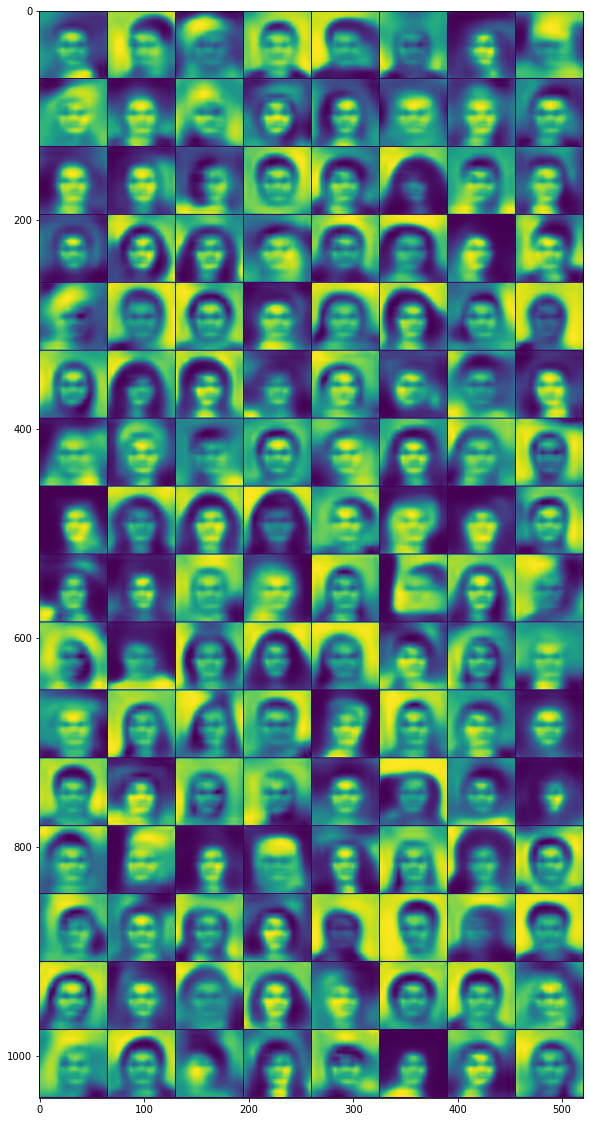

In [48]:
show_images(images.cpu())
show_images(xp.detach().cpu())